# Определение стоимости автомобилей

**Описание задачи**    
Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

**Признаки**   
`DateCrawled` — дата скачивания анкеты из базы    
`VehicleType` — тип автомобильного кузова    
`RegistrationYear` — год регистрации автомобиля    
`Gearbox` — тип коробки передач    
`Power` — мощность (л. с.)    
`Model` — модель автомобиля    
`Kilometer` — пробег (км)    
`RegistrationMonth` — месяц регистрации автомобиля    
`FuelType` — тип топлива    
`Brand` — марка автомобиля    
`NotRepaired` — была машина в ремонте или нет     
`DateCreated` — дата создания анкеты    
`NumberOfPictures` — количество фотографий автомобиля    
`PostalCode` — почтовый индекс владельца анкеты (пользователя)    
`LastSeen` — дата последней активности пользователя     

**Целевой признак**    
`Price` — цена (евро)

**План работы**

В первую очередь надо изучить данные. Поискать дубликаты, выбросы. Предположить какие признаки не несут полезной информации для целевого признака. 

Потом подготовить данные для ML. 
Для деревянных моделей буду использовать OrdinalEncoder, для остальных попробую OHE

С моделей буду извлекать время обучения, скорость предсказания, и качество на тренировочной выборке. 
После выберу лучшую модель и посмотрю качество на тестовой выборке

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv

plt.style.use('seaborn-darkgrid')
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
shape0 = df.shape #сохраняю размер датафрейма до обработки 
shape0

(354369, 16)

Нам дан датасет на 354369 строк

In [4]:
df.head()  #вывожу первые пять строк

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Можно заметить, что в датасете присутствуют пропуски. Выведем информацию о Dtype    

In [5]:
df.info()  # вывожу информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
date = ['DateCrawled', 'DateCreated', 'LastSeen'] # изменяю тип данных
df[date] = df[date].astype('datetime64')

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В столбце `RegistrationYear` видны выбросы в виде года регистрации в 1000 и 9999 лет   
В `power` виднеются значения в виде минимальной мощности в 0 и максимальной 20000    
В `NumbersOfPictures` все значения нулевые. Их можно удалить     
В `RegistrationMonth` дано 13 месяцев? С 0го по 12? Надо проверить    
В `Price` есть минимальная стоимость в виде 0. Посмотрим на целевую переменную в самом конце
    
Так же помимо `NumbersOfPictures` предлагаю удалить    
`DateCrawled` поскольку цена на анкете не будет завизить от даты скачивания её с базы     
`PostalCode` поскольку почтовый индекс владельца не влияет на стоимость автомобиля (хотя тут смелое заявление, региональные цены ведь есть)      
`LastSeen` от последней активности стоимость автомобиля не зависит     

Так же перед удалением лишних столбцов надо провести проверку на явные дубликаты 

In [8]:
df.duplicated().sum()#проверяю датасет на явные дубликаты

4

In [9]:
df.drop_duplicates(inplace = True) #удаляю явные дубликаты 
df.drop(['NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1, inplace = True) #удаляем столбцы

Надо проверить, что бы дата создания анкеты не была позже  года регистрации автомобиля. Идеи как исправить данную ошибку нет. Это критичная ошибка в заполнении данных. Потому предлагаю удалить те строки где создание анкеты происходило раньше регистрации автомобиля

In [10]:
df = df[df['DateCreated'].dt.year >= df['RegistrationYear']]  #удаляем аномальные значение годов 
df.shape # смотрим на размер таблицы 

(339835, 13)

После удаления лишних значений у нас остаётся 339839 строк. Посмотрим на аномалии в `Power` и `RegistrationYear`

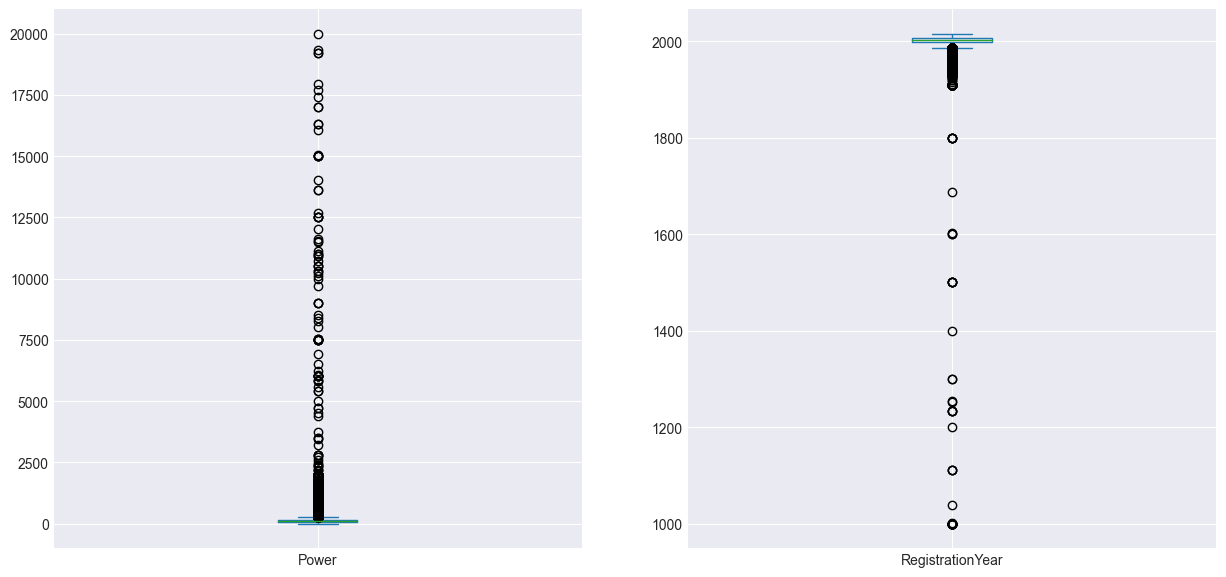

In [11]:
df.loc[:,['Power', 'RegistrationYear']].plot(kind = 'box', figsize = (15, 7), subplots = True);

В `RegistratonYear` предлагаю удалить значения ниже 1 процентиля. Ошибки в данной колонке должны сразу отметаться. Поскольку сомневаюсь, что есть автомобили 1000года производства. Хотя возможно это назад в будущее 4?      
В `Power` посмотрим на корреляцию, что бы решить как будем заменять значения

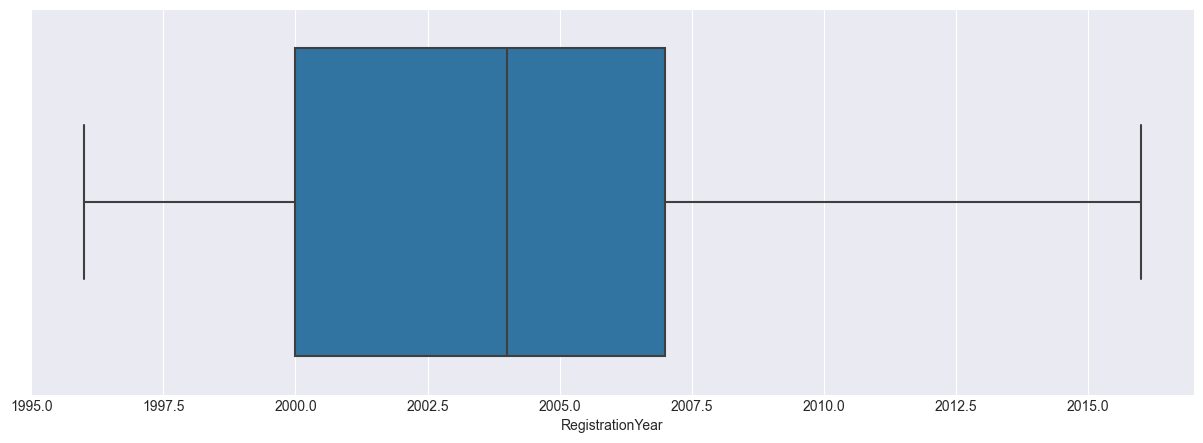

In [12]:
df = df[df['RegistrationYear'] > df['RegistrationYear'].quantile(0.1)]

fig = plt.figure(figsize=(15,5))
sns.boxplot(x = df['RegistrationYear'])
plt.show()

В датасете мы оставили только те машины у которых была дата регистрации от 1995 до 2015 года

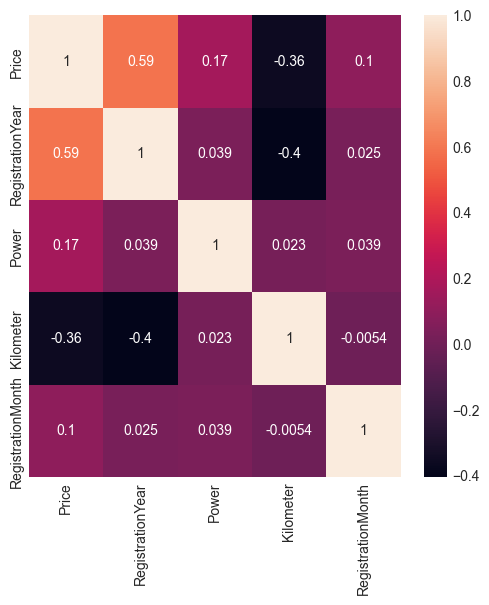

In [13]:
fig = plt.figure(figsize = (6,6))
sns.heatmap(df.corr(), annot = True)
plt.show();

Числовые признаки почти ни как не коррелируют друг с другом.    
Высокое значение только у `RegistrationYear` с `Price`. Возможно наше решение удаление аномалий  была верным решением   
Посмотрим на `Power` повнимательней

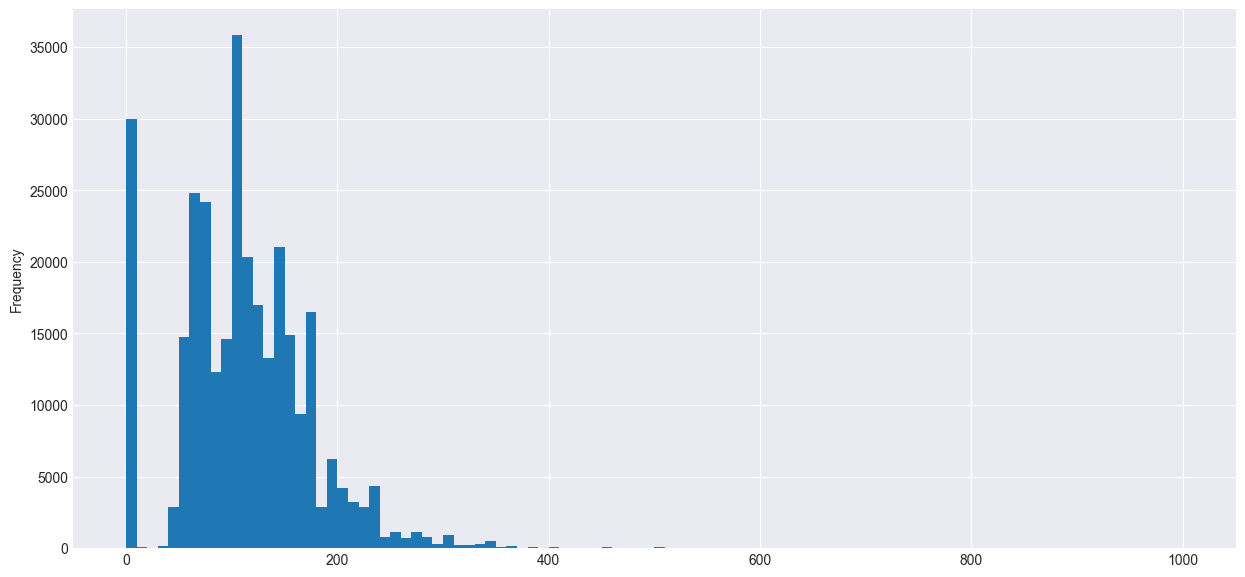

In [14]:
df['Power'].plot(kind =  'hist', bins = 100, figsize = (15,7), grid = True, range = (0, 1000));

Мы наблюдаем много нулевых значений. И очень много выбросов в виде мощности в 1000 лошадинных сил(P.s. это мы ещё ограничили график по оси 0Х) 

In [15]:
df.query('0 < Power < 400', inplace = True) #делаю срез. 

In [16]:
df['RegistrationMonth'].nunique() # проверим теорию о количестве месяцев в месяце регистрации автомобиля 

13

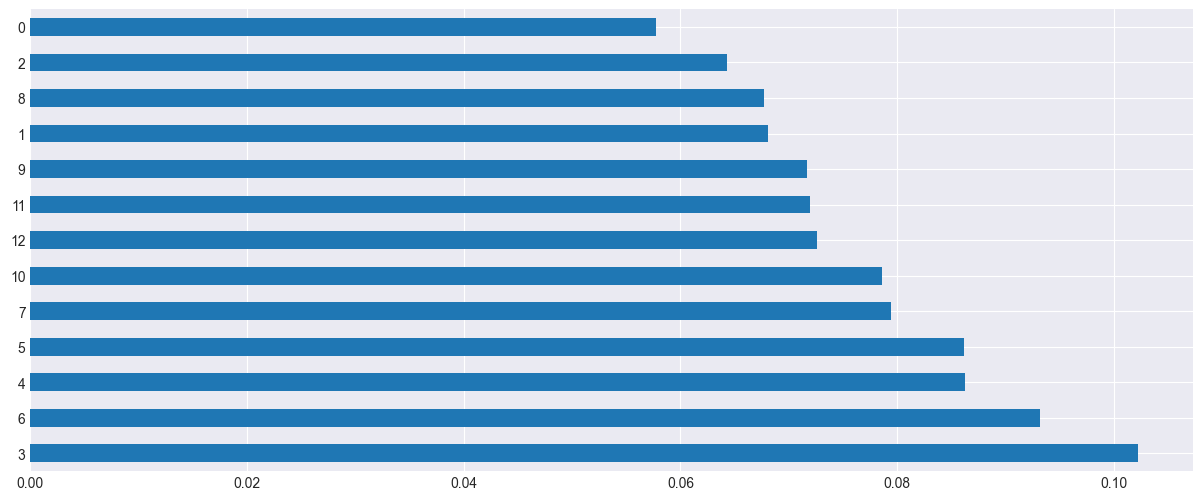

In [17]:
df['RegistrationMonth'].value_counts(normalize = True).plot(kind = 'barh', figsize = (15, 6), grid = True);

Как исправить ошибку в месяце регистрации автомобиля идеи нет. Удалять почти 6% датасета не хочется.    
Потому делаю предположение, что месяц регистрации не сильно влияет на стоимость автомобиля и просто удалю данный столбец

In [18]:
df.drop(['RegistrationMonth'], axis = 1, inplace = True)

Переходим к обработке пропусков

In [19]:
df.isna().mean().to_frame()

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,0.038798
RegistrationYear,0.000000
Gearbox,0.018067
Power,0.000000
Model,0.035076
Kilometer,0.000000
FuelType,0.051881
Brand,0.000000


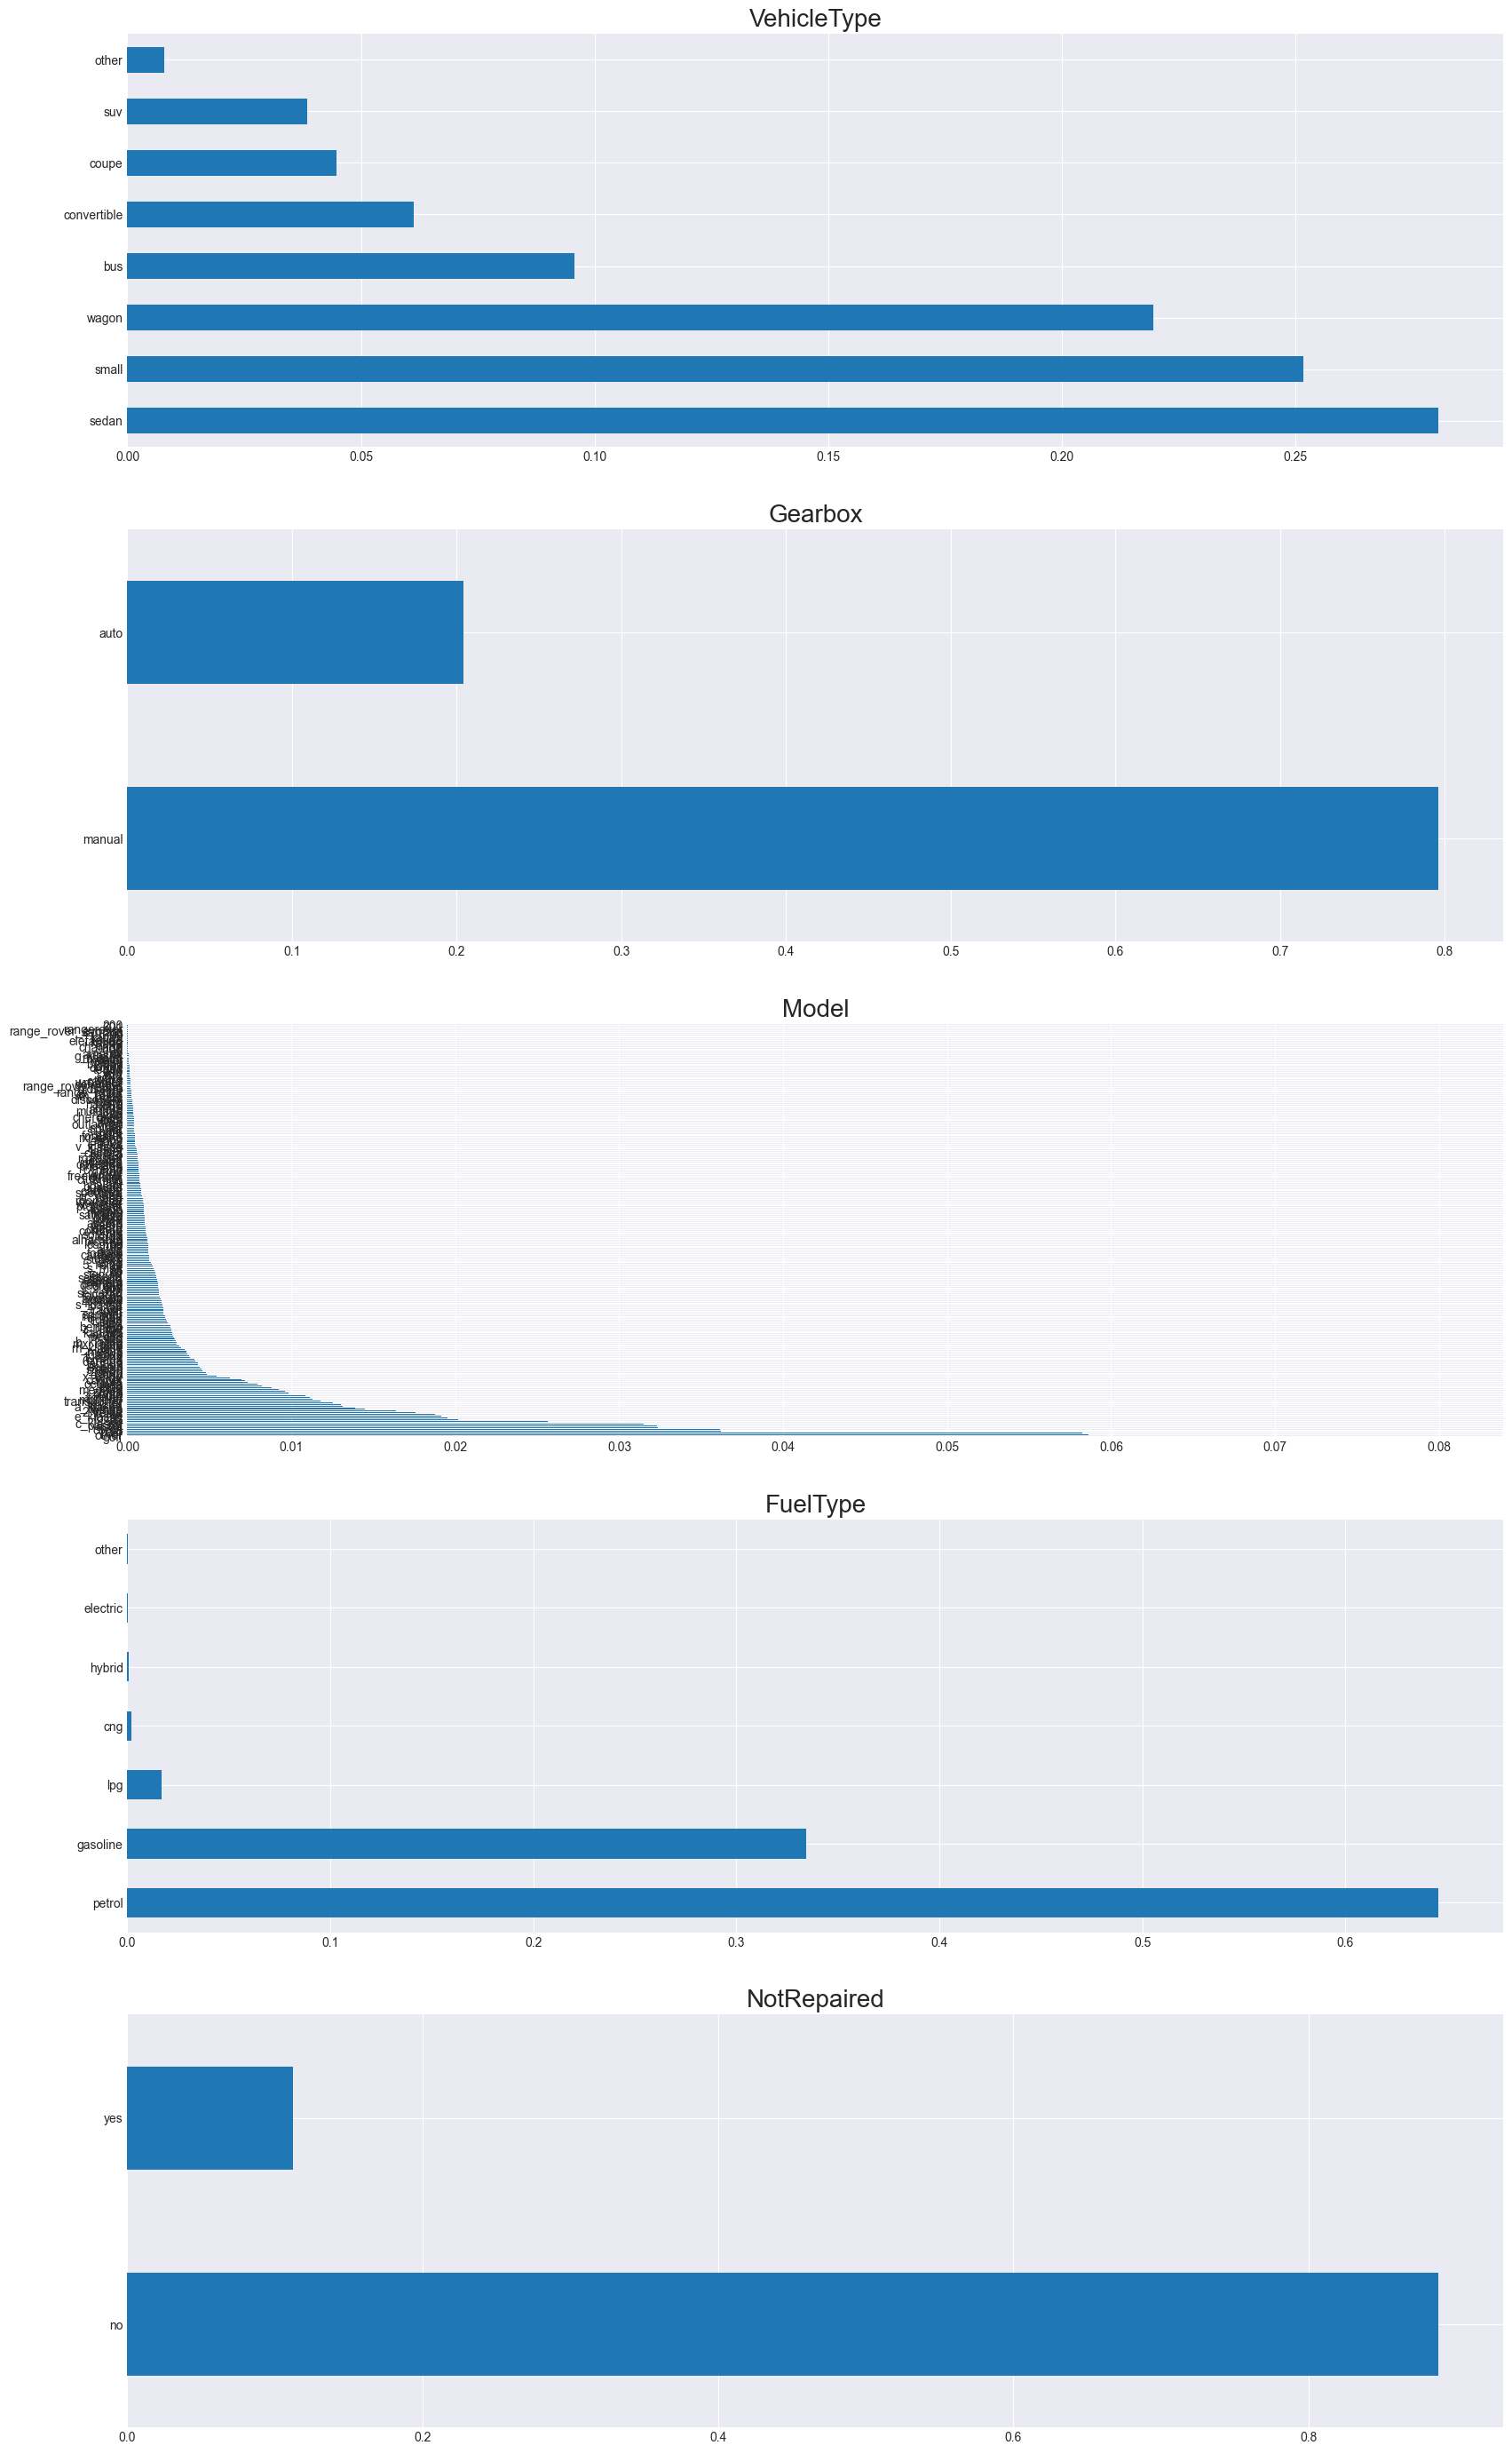

In [20]:
isna = [i for i in df.columns if df[i].isna().sum() != 0]
fig = plt.figure(figsize = (20,35))
for i in range(len(isna)):
    data = df[isna[i]]
    plt.subplot(len(isna), 1, i+1)
    data.value_counts(normalize = True).plot(kind = 'barh')
    plt.title(isna[i], fontdict = {'fontsize' : 20})

Можно было использовать заполнение пропусков модой в некоторых столбцах, поскольку в большинстве столбцов мода составляет более 60%, а значением пропусков менее 4%. 
А в других воспользоваться удалением пропусков.   
Но поскольку пропуски есть в категориальных столбцах я выбрал заполнить пропуски неизвестным

In [21]:
df.loc[:,isna] = df.loc[:,isna].fillna('unknown')

Посмотрим так же на распределение нашего целового значения

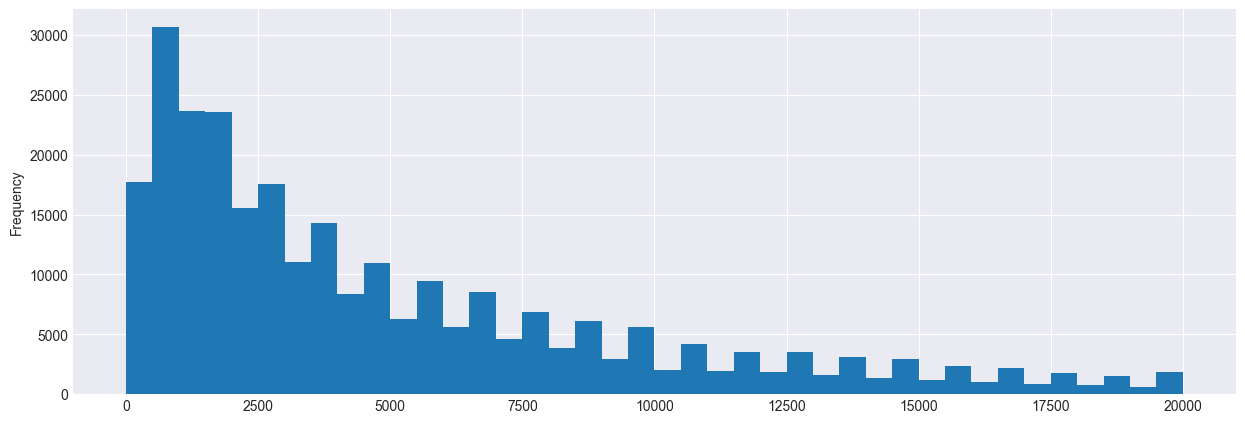

In [22]:
df['Price'].plot(kind = 'hist', bins = 40, figsize = (15,5), grid = True);

Имеется всплеск в районе 0 значения. Далее у нас идёт затухание целевого признака по экспоненте. Предлагаю посмотреть значения около нуля

In [23]:
df.loc[df['Price'] < 10, 'Price'].value_counts()

0    5022
1     509
2       6
5       6
3       4
9       1
Name: Price, dtype: int64

Наблюдаем, что у нас есть всплеск значений 0 и 1. Возможно на сайте нет ограничения в минимальной стоимости автомобиля. И клиенты могут случайно создать заявку указав 0 стоимость 

In [24]:
df.query('Price > 1', inplace = True)

Так же создам дополнительные столбцы с годом, месяц, днём создания анкеты 

In [25]:
df['YearCrawled'] = df['DateCrawled'].dt.year
df['MonthCrawled'] = df['DateCrawled'].dt.month
df['DayCrawled'] = df['DateCrawled'].dt.day
df.drop(['DateCrawled'], axis = 1, inplace = True)

In [26]:
df['YearCreated'] = df['DateCreated'].dt.year
df['MonthCreated'] = df['DateCreated'].dt.month
df['DayCreated'] = df['DateCreated'].dt.day
df.drop(['DateCreated'], axis = 1, inplace = True)

In [27]:
df.reset_index(drop = True, inplace = True) #обновлю значения индексов

In [28]:
shape1 = df.shape
shape1

(267729, 16)

In [29]:
shape0[0] - shape1[0]

86640

В результате обработки было удалено 86640 строк 

**Применение train_test_split**

In [30]:
target = df['Price']
features = df.drop(['Price'], axis = 1)

target_train, target_test, features_train, features_test =  train_test_split(
    target, features, test_size = 0.33, random_state = 83213)

In [31]:
for x,y,z in zip((target_train, target_test),(features_train, features_test), ('тренировочной', 'тестовой')):
    print(f'В {z} выборке, размеры матрицы признаков  = {y.shape}, целевого признака = {x.shape}')

В тренировочной выборке, размеры матрицы признаков  = (179378, 15), целевого признака = (179378,)
В тестовой выборке, размеры матрицы признаков  = (88351, 15), целевого признака = (88351,)


**Кодирование категориальных переменных при помощи OHE** 

In [32]:
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

train_one = features_train.reset_index(drop = True).copy()
test_one = features_test.reset_index(drop = True).copy()

onehot_encoder = OneHotEncoder(sparse = False, drop = 'first', dtype = 'int64')

train_one_cat_cols = pd.DataFrame(onehot_encoder.fit_transform(train_one[cat_cols]))
train_one.drop(cat_cols, axis = 1, inplace = True)
train_one = pd.concat([train_one, train_one_cat_cols], axis = 1)
train_one.rename(columns = lambda x:str(x), inplace = True)

test_one_cat_cols = pd.DataFrame(onehot_encoder.transform(test_one[cat_cols]))
test_one.drop(cat_cols, axis = 1, inplace = True)
test_one = pd.concat([test_one, test_one_cat_cols], axis = 1)
test_one.rename(columns = lambda x:str(x), inplace = True)

**Применение StandardScaler для числовых переменных**

In [33]:
num_cols = ['RegistrationYear', 'Power', 'Kilometer', 'YearCreated', 'MonthCreated', 'DayCreated', 'YearCreated', 
            'MonthCreated', 'DayCreated']

scaler = StandardScaler()
scaler.fit(train_one[num_cols])

train_one[num_cols] = scaler.transform(train_one[num_cols])
test_one[num_cols] = scaler.transform(test_one[num_cols])

## Обучение моделей

Для обучения модели использую метрику rmse

In [34]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions)**0.5

scorer = make_scorer(rmse, greater_is_better=False)

In [35]:
def model_training(model, parametrs, x_train = train_one, y_train = target_train):
    grid = GridSearchCV(model, parametrs, cv = 5, scoring=scorer, verbose = 5)
    grid.fit(x_train, y_train)  
    print(grid.best_estimator_)
    
    ml = grid.best_estimator_  #отбираем наилучшие параметры при помощи GridSearchCV    
    
    start1 = time.time()
    ml.fit(x_train, y_train)
    finish1 = time.time() - start1
    print('Время обучения на тренировочной выборке составило ', finish1)
    
    start2 = time.time()
    predict =  ml.predict(x_train)
    finish2 = time.time() - start2
    print('Время предсказания на тренировочной выборке составило ', finish2)
    
    print('оценка RMSE на кросс валидации = ', -(grid.best_score_))
    
    return -(grid.best_score_), finish1, finish2  

**Линейная регрессия**

In [36]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False]}

score, finish1, finish2 = model_training(model, parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ............fit_intercept=True;, score=-2237.613 total time=   6.0s
[CV 2/5] END ............fit_intercept=True;, score=-2201.348 total time=   5.8s
[CV 3/5] END .......fit_intercept=True;, score=-396195732.658 total time=   6.8s
[CV 4/5] END ............fit_intercept=True;, score=-2225.837 total time=   7.2s
[CV 5/5] END ............fit_intercept=True;, score=-2198.189 total time=   6.1s
[CV 1/5] END ...........fit_intercept=False;, score=-2237.447 total time=   5.7s
[CV 2/5] END ...........fit_intercept=False;, score=-2201.348 total time=   5.9s
[CV 3/5] END ...........fit_intercept=False;, score=-2227.948 total time=   6.1s
[CV 4/5] END ...........fit_intercept=False;, score=-2225.837 total time=   7.2s
[CV 5/5] END ...........fit_intercept=False;, score=-2198.333 total time=   7.4s
LinearRegression(fit_intercept=False)
Время обучения на тренировочной выборке составило  8.121455192565918
Время предсказания на т

In [37]:
result = pd.DataFrame({'модель':['Линейная регрессия'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.18269,8.121455,0.377461


**Градиентный бустинг**

In [38]:
model = GradientBoostingRegressor(random_state= 46754)
parameters = {'n_estimators': range (50, 81, 10), 'max_depth': range (3,5)}

score, finish1, finish2 = model_training(model, parameters)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..max_depth=3, n_estimators=50;, score=-1966.334 total time=  48.6s
[CV 2/5] END ..max_depth=3, n_estimators=50;, score=-1909.656 total time=  47.0s
[CV 3/5] END ..max_depth=3, n_estimators=50;, score=-1956.363 total time=  45.8s
[CV 4/5] END ..max_depth=3, n_estimators=50;, score=-1966.307 total time=  42.3s
[CV 5/5] END ..max_depth=3, n_estimators=50;, score=-1926.571 total time=  42.9s
[CV 1/5] END ..max_depth=3, n_estimators=60;, score=-1916.551 total time=  50.3s
[CV 2/5] END ..max_depth=3, n_estimators=60;, score=-1858.975 total time=  50.0s
[CV 3/5] END ..max_depth=3, n_estimators=60;, score=-1906.247 total time=  53.1s
[CV 4/5] END ..max_depth=3, n_estimators=60;, score=-1919.945 total time=  57.3s
[CV 5/5] END ..max_depth=3, n_estimators=60;, score=-1875.736 total time=  59.3s
[CV 1/5] END ..max_depth=3, n_estimators=70;, score=-1881.605 total time= 1.1min
[CV 2/5] END ..max_depth=3, n_estimators=70;, sco

In [39]:
result1 = pd.DataFrame({'модель':['Градиентный бустинг'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,8.121455,0.377461
1,Градиентный бустинг,1729.870244,122.120802,1.276011


**LightGBM**

In [40]:
model = LGBMRegressor(random_state=45648741)
parametrs = {'n_estimators': range(100,131, 10), 'num_leaves': range(31,42,10)}

score, finish1, finish2 = model_training(model, parametrs)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END n_estimators=100, num_leaves=31;, score=-1603.312 total time=   2.4s
[CV 2/5] END n_estimators=100, num_leaves=31;, score=-1562.505 total time=   2.1s
[CV 3/5] END n_estimators=100, num_leaves=31;, score=-1586.476 total time=   2.1s
[CV 4/5] END n_estimators=100, num_leaves=31;, score=-1604.572 total time=   2.1s
[CV 5/5] END n_estimators=100, num_leaves=31;, score=-1554.592 total time=   2.1s
[CV 1/5] END n_estimators=100, num_leaves=41;, score=-1580.778 total time=   2.1s
[CV 2/5] END n_estimators=100, num_leaves=41;, score=-1541.459 total time=   2.2s
[CV 3/5] END n_estimators=100, num_leaves=41;, score=-1565.499 total time=   2.2s
[CV 4/5] END n_estimators=100, num_leaves=41;, score=-1583.212 total time=   2.4s
[CV 5/5] END n_estimators=100, num_leaves=41;, score=-1530.415 total time=   2.2s
[CV 1/5] END n_estimators=110, num_leaves=31;, score=-1595.513 total time=   2.1s
[CV 2/5] END n_estimators=110, num_lea

In [41]:
result1 = pd.DataFrame({'модель':['LightGBM'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,8.121455,0.377461
1,Градиентный бустинг,1729.870244,122.120802,1.276011
2,LightGBM,1542.058381,2.355690,1.286999


**Catboost**

In [42]:
encoder = OrdinalEncoder()

ordinal_train = features_train.reset_index(drop=True).copy()
ordinal_train[cat_cols] = encoder.fit_transform(ordinal_train[cat_cols])

ordinal_test = features_test.reset_index(drop=True).copy()
ordinal_test[cat_cols] = encoder.transform(ordinal_test[cat_cols])

In [43]:
model = CatBoostRegressor(random_state=234, verbose=False)
parametrs = {'depth': [4,5],
             'learning_rate' : [0.01,0.02]}

grid = GridSearchCV(model, parametrs, cv = 3, scoring=scorer, verbose = 3)
grid.fit(ordinal_train, target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...depth=4, learning_rate=0.01;, score=-1809.921 total time=   9.7s
[CV 2/3] END ...depth=4, learning_rate=0.01;, score=-1821.311 total time=   9.2s
[CV 3/3] END ...depth=4, learning_rate=0.01;, score=-1797.791 total time=   9.0s
[CV 1/3] END ...depth=4, learning_rate=0.02;, score=-1710.330 total time=   9.0s
[CV 2/3] END ...depth=4, learning_rate=0.02;, score=-1720.552 total time=   9.2s
[CV 3/3] END ...depth=4, learning_rate=0.02;, score=-1694.995 total time=   9.1s
[CV 1/3] END ...depth=5, learning_rate=0.01;, score=-1751.943 total time=  11.2s
[CV 2/3] END ...depth=5, learning_rate=0.01;, score=-1761.536 total time=  11.3s
[CV 3/3] END ...depth=5, learning_rate=0.01;, score=-1740.354 total time=  10.7s
[CV 1/3] END ...depth=5, learning_rate=0.02;, score=-1665.000 total time=  10.5s
[CV 2/3] END ...depth=5, learning_rate=0.02;, score=-1667.219 total time=  10.3s
[CV 3/3] END ...depth=5, learning_rate=0.02;, sco

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002498A226280>,
             param_grid={'depth': [4, 5], 'learning_rate': [0.01, 0.02]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=3)

In [44]:
ml_cat = grid.best_estimator_
start1 = time.time()
ml_cat.fit(ordinal_train, target_train)
finish1 = time.time() - start1

In [45]:
start2 = time.time()
predict =  ml_cat.predict(ordinal_train)
finish2 = time.time() - start2
print('Время предсказания на тренировочной выборке составило ', finish2)
print('Время обучения на тренировочной выборке составило ', finish1)

Время предсказания на тренировочной выборке составило  0.05399155616760254
Время обучения на тренировочной выборке составило  15.97615647315979


In [46]:
score = rmse(target_train, ml_cat.predict(ordinal_train))
print('RMSE на тренировочной выборке = ', score)

RMSE на тренировочной выборке =  1644.8659659318753


In [47]:
result1 = pd.DataFrame({'модель':['Catboost'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,8.121455,0.377461
1,Градиентный бустинг,1729.870244,122.120802,1.276011
2,LightGBM,1542.058381,2.355690,1.286999
3,Catboost,1644.865966,15.976156,0.053992


**Случайный лес**

In [48]:
model = RandomForestRegressor(random_state= 12378)
parametrs = {'n_estimators': range (50, 81, 10), 'max_depth': range (3,5)}

score, finish1, finish2 = model_training(model, parametrs, x_train = ordinal_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ..max_depth=3, n_estimators=50;, score=-2873.217 total time=   4.8s
[CV 2/5] END ..max_depth=3, n_estimators=50;, score=-2844.940 total time=   4.8s
[CV 3/5] END ..max_depth=3, n_estimators=50;, score=-2863.996 total time=   5.1s
[CV 4/5] END ..max_depth=3, n_estimators=50;, score=-2860.030 total time=   5.0s
[CV 5/5] END ..max_depth=3, n_estimators=50;, score=-2831.253 total time=   5.1s
[CV 1/5] END ..max_depth=3, n_estimators=60;, score=-2873.206 total time=   6.0s
[CV 2/5] END ..max_depth=3, n_estimators=60;, score=-2842.512 total time=   6.1s
[CV 3/5] END ..max_depth=3, n_estimators=60;, score=-2865.217 total time=   5.8s
[CV 4/5] END ..max_depth=3, n_estimators=60;, score=-2859.873 total time=   5.9s
[CV 5/5] END ..max_depth=3, n_estimators=60;, score=-2830.810 total time=   5.9s
[CV 1/5] END ..max_depth=3, n_estimators=70;, score=-2871.619 total time=   7.1s
[CV 2/5] END ..max_depth=3, n_estimators=70;, sco

In [49]:
result1 = pd.DataFrame({'модель':['Случайный лес'], 'rmse': [score], 'время обучения': [finish1], 
                        'время предсказания': [finish2]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,rmse,время обучения,время предсказания
0,Линейная регрессия,2218.182690,8.121455,0.377461
1,Градиентный бустинг,1729.870244,122.120802,1.276011
2,LightGBM,1542.058381,2.355690,1.286999
3,Catboost,1644.865966,15.976156,0.053992
4,Случайный лес,2491.521752,13.771008,0.668001


## Анализ моделей

В таблице `result` предоставленны результаты с оценкой, временем обучения и временем предсказания.    
Самое быстрое время и качество обучения у `lightGBM`    
В то время как время предсказания лучше всего у `Сatboost`   
Попробуем применить модели  `lightGBM` и `Catboost` на тестовой выборке

**LightGBM**

In [50]:
model = LGBMRegressor(n_estimators=130, num_leaves=41, random_state=45648741) #наилучшие параметры модели
model.fit(train_one, target_train)

LGBMRegressor(n_estimators=130, num_leaves=41, random_state=45648741)

In [51]:
%%time
score = rmse(target_test, model.predict(test_one))

print('RMSE на тестовой выборке = ', score)

RMSE на тестовой выборке =  1540.464754581676
CPU times: total: 3.83 s
Wall time: 820 ms


**Catboost**

In [52]:
%%time
score = rmse(target_test, ml_cat.predict(ordinal_test))

print('RMSE на тестовой выборке = ', score)

RMSE на тестовой выборке =  1646.0209840062325
CPU times: total: 172 ms
Wall time: 36 ms


## Вывод 

Заказчику рекомендуется использовать на выбор `LightGBM` и `Catboost`   
Если ему важно качество предсказание и время обучения то используется первая модель. RMSE достигает `1542.058381` против `1644.865966` у `Сatboost`.       

В случае того, если будет сделан упор на время предсказания то `Сatboost` безусловный лидер. 
`0.053992` против `1.286999`